# Inspiration and Software

I stumbled across Jake Vanderplas's blog post [Analyzing Pronto CycleShare Data with Python and Pandas](https://jakevdp.github.io/blog/2015/10/17/analyzing-pronto-cycleshare-data-with-python-and-pandas/) and thought it could be interesting to do something similar for the data from Washington DC's Capital Bikeshare. I'll also use python, numpy, and pandas, but I've opted for [plot.ly](https://plot.ly) to generate the graphs. I think plotly has some nice defaults and I like the interactive plots that it generates as opposed ot the static images that matplotlib and seaborn make. Another option could be [bokeh](http://bokeh.pydata.org/en/latest/) by the PyData folks or if you really want to get your hands dirty [D3.js](https://d3js.org/).

[Capital Bikeshare](https://www.capitalbikeshare.com/) has tons of data going back to 2010. I'm starting here with the first data available, the last quarter of 2010. In the future I'm going to work on some data on a yearly basis and also do some year over year comparisons. Unfortunately, the formatting in the data that Capital Bikeshare provides is not consistent, so it is a little more work than just loading a different CSV file. 

In [1]:
import pandas as pd
import re
from datetime import timedelta
import plotly
import xml.etree.ElementTree as et
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
from plotly.graph_objs import Data, Scatter, Layout, Figure, Histogram
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.core.display import display, HTML
import gmaps
from IPython.display import Image

plotly.offline.init_notebook_mode()

<IPython.core.display.Javascript object>

# Getting the Data

The site that Capital Bikeshare uses to host their data looks like a simple directory index page, but actually requires javascript to load the table, so we can't use something simple like python's request library and beautifulsoup. Instead, I've opted for splinter, which uses phantomjs, a headless browser, to download and navigate the DOM to get the links for all the data. Once I have the direct links, I can simply use python's urllib to download them, shutil to save them, and zipfile to unzip them. The code to do all that is below.

The station data is simpler to downlad because there's only one file and we can easily get the direct link. 

The data are saved to a directory called data that is within the directory where this notebook lives.

In [2]:
from splinter import Browser
import os
import urllib.request
import shutil
import zipfile
import xml.etree.ElementTree as et

#current_dir = os.path.dirname(__file__)

def get_links():
    browser = Browser('phantomjs')
    browser.visit('https://s3.amazonaws.com/capitalbikeshare-data/index.html')

    links = browser.find_by_css('#tbody-content a')
    #links = [link for link in links if link['href']]
    zip_links = []
    for link in links:
        link_text = link['href']
        with urllib.request.urlopen(link_text) as response:
            subtype = response.info().get_content_subtype()
            if subtype == 'zip':
                zip_links.append(link_text)

    return zip_links


def download_links(links):
    download_dir = 'data'
    if not os.path.exists(download_dir):
        os.mkdir(download_dir)
    for link in links:
        file_name = os.path.join(download_dir, link.split('/')[-1])
        print(file_name)
        # save file to disk
        with urllib.request.urlopen(link) as response, open(file_name, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        with zipfile.ZipFile(file_name, "r") as zip_ref:
            zip_ref.extractall(download_dir)

def get_station_xml():
    url = "https://www.capitalbikeshare.com/data/stations/bikeStations.xml"
    download_dir = 'data'
    if not os.path.exists(download_dir):
        os.mkdir(download_dir)
    file_name = os.path.join(download_dir, 'bike_stations.xml')
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

#links = get_links()
#download_links(links)
#get_station_xml()





# Loading, parsing, and cleaning the data

Loading the CSV data is dead simple since pandas has a [read_csv](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) method. It can even parse datetime strings while reading, making our lives even easier. Unfortunately the duration strings are not in any standard format, but we can use regular expressions to parse those. The station data has satation name information that we don't need, so we use a different regular expression to match just the station code. Finally we drop some missing data (some people never return their bikes it seems), convert column data types, and our usage data is nice.

The bike station data is not quite as simple to parse. It's an XML file which has a tree type structure, while dataframes are essentially a 2D table. The two are not always compatible, so we have to hand write a function to load the data into a dataframe. Using python's XML libraries makes this not too painful as we can simply loop through the child nodes at each level to extract tag and text information.

In [3]:
time_regex = re.compile(r'((?P<hours>\d+?)h )?((?P<minutes>\d+?)min. )?((?P<seconds>\d+?)sec.)?')
def parse_time(time_str):
    parts = time_regex.match(time_str)
    if not parts:
        return
    parts = parts.groupdict()
    time_params = {}
    for (name, param) in parts.items():
        if param:
            time_params[name] = int(param)
    return timedelta(**time_params)

station_regex = re.compile(r'\((?P<code>\d+?)\)')
def parse_stations(station_str):
    try:
        station_code = int(station_regex.search(station_str).group('code'))
    except ValueError:
        station_code = None
    except TypeError:
        station_code = None
    return station_code

def xml_to_pandas(xml_file):
    tree = et.parse(xml_file)
    root = tree.getroot()

    l = []
    for station in root:
        d = {}
        for attrib in station:
            d[str(attrib.tag)] = str(attrib.text)
            #print("    " + str(attrib.tag) + " : " + str(attrib.text))
        l.append(d)

    df = pd.DataFrame.from_dict(l)
    return df
    

data = pd.read_csv('data/2010-Q4-cabi-trip-history-data.csv',
                   parse_dates=['Start date', 'End date'], infer_datetime_format=True)
data['Duration'] = data['Duration'].apply(parse_time)
data['Start station'] = data['Start station'].apply(parse_stations)
data['End station'] = data['End station'].apply(parse_stations)
data = data.dropna()
# after dropping some columns we can convert from float to int
data['End station'] = data['End station'].astype(int)
    
bike_stations = xml_to_pandas('data/bike_stations.xml')
bike_stations['terminalName'] = bike_stations['terminalName'].astype(int)
bike_stations['lat'] = bike_stations['lat'].astype(float)
bike_stations['long'] = bike_stations['long'].astype(float)
station_locations = bike_stations[['terminalName']]
station_locations['location'] = list(zip(bike_stations['lat'], bike_stations['long']))

data.head(5)

/Users/keith/.virtualenvs/capitalbikeshare/lib/python3.5/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Duration          Start date            End date  Start station  \
0  14:26:02 2010-12-31 23:49:00 2011-01-01 14:15:00          31111   
1  00:08:34 2010-12-31 23:37:00 2010-12-31 23:46:00          31111   
2  00:12:17 2010-12-31 23:27:00 2010-12-31 23:39:00          31602   
3  00:15:53 2010-12-31 23:21:00 2010-12-31 23:37:00          31106   
4  00:36:19 2010-12-31 23:20:00 2010-12-31 23:56:00          31110   

   End station   Bike# Member Type  
0        31111  W00771      Casual  
1        31202  W01119  Registered  
2        31401  W00973  Registered  
3        31401  W00914  Registered  
4        31623  W00859      Casual

In [4]:
station_locations.head()

terminalName                 location
0         31000  (38.858662, -77.053199)
1         31001    (38.85725, -77.05332)
2         31002  (38.856425, -77.049232)
3         31003   (38.86017, -77.049593)
4         31004   (38.857866, -77.05949)

# Merging the usage and station data

Now we could keep the usage and station data in two separate dataframes and simply look up location information on the fly as we need, but I find it easier to combine all the data that we need now and then simply use it later. To this end, we can use pandas's [merge](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) method (which is like a SQL join) to combine the dataframes.

In [5]:
data = data.merge(station_locations, how='left', left_on='Start station', right_on='terminalName')
data.columns = [w if w != 'location' else 'start location' for w in data.columns]
data.drop('terminalName', axis=1, inplace=True)

data = data.merge(station_locations, left_on='End station', right_on='terminalName')
data.columns = [w if w != 'location' else 'end location' for w in data.columns]
data.drop('terminalName', axis=1, inplace=True)

# Estimating trip distances

Given the station location data and the start and end stations for a trip, we can estimate approximately how far a rider traveled on his or her trip. Or rather, more accurately, we can estimate the lower bound of the distance that they traveled. In the blog post that inspired this one, the author uses the Google Maps distances API to estimate the distance traveled. That worked great for the Seattle bikeshare system which has only 55 stations or not even 1500 station combination pairs. DC has over 350 stations and with the free limit on the API of 2500 distances per day, it would take over 12 days to generate a distance matrix. Ain't nobody got time for that. Instead, we use the [geopy library](https://github.com/geopy/geopy) to estimate the distance between coordinates using [Vincenty's formulae](https://en.wikipedia.org/wiki/Vincenty%27s_formulae) which calculates the "distance between two points on the surface of a spheroid," like our Earth. Now obviously this ignore things like roads and rivers – actual route possibilitiies – but will still work as a lower bound

In [6]:
data['distance'] = data.apply(lambda row: distance(row['start location'], row['end location']).miles, axis=1)

# Finally some pictures

The first thing we'll look at is how usage varies over time. However, we are separating the usage by "membership type." Capital Bikeshare offers short- and long-term memberships and in the data they refer to these groups as "Casual" and "Registered" members, respectively. One can imagine that a long-term member (a commuter perhaps) would have different usage patterns than just a casual member. We'll find out either way if this is in fact the case.

In [7]:
by_date_casual = data.groupby(data[data['Member Type'] == 'Casual']['Start date'].dt.date).count()
by_date_registered = data.groupby(data[data['Member Type'] == 'Registered']['Start date'].dt.date).count()
layout = Layout(
    title='Casual member usage by date',
    xaxis=dict(
        title='Date',
    ),
    yaxis=dict(
        title='Number of trips',
    )
)
plot_data = [
    Scatter(
        x=by_date_casual.index, # assign x as the dataframe column 'x'
        y=by_date_casual['Duration']
    )
]
fig = Figure(data=plot_data,layout=layout)
iplot(fig)
layout['title'] = 'Registered member usage by date'
plot_data = [
    Scatter(
        x=by_date_registered.index, # assign x as the dataframe column 'x'
        y=by_date_registered['Duration']
    )
]
fig = Figure(data=plot_data,layout=layout)

iplot(fig)

From the cell above we can a general increasing then decreasing trend, particularly as the weather gets colder. There are very few riders around Christmas (and in my experience the whole city tends to shutdown and many, many people leave the city).

In [8]:
by_day_casual = data.groupby(data[data['Member Type'] == 'Casual']['Start date'].dt.dayofweek).count()
by_day_registered = data.groupby(data[data['Member Type'] == 'Registered']['Start date'].dt.dayofweek).count()
layout = Layout(
    title='Casual member usage by day of week',
    xaxis=dict(
        title='Day',
        ticktext=[
            'Mon','Tue','Wed','Thu','Fri','Sat','Sun'
        ],
        tickvals = list(range(7))
    ),
    yaxis=dict(
        title='Number of trips',
    )
)
plot_data = [
    Scatter(
        x=by_day_casual.index, # assign x as the dataframe column 'x'
        y=by_day_casual['Duration']
    )
]
fig = Figure(data=plot_data,layout=layout)
iplot(fig)
layout['title'] = 'Registered member usage by day of week'
plot_data = [
    Scatter(
        x=by_day_registered.index, # assign x as the dataframe column 'x'
        y=by_day_registered['Duration']
    )
]
fig = Figure(data=plot_data,layout=layout)
iplot(fig)

Here we see, expectedly, that casual member usage spikes during the weekends while registered members (commuters perhaps) dives on the weekends. We can also look at weekend vs. weekday usage for casual and registered members a little more closely.

In [9]:
# filter out the rows that don't have a start location
data = data[data['start location'].apply(lambda row: True if isinstance(row,tuple) else False)]
# and end location
data = data[data['end location'].apply(lambda row: True if isinstance(row,tuple) else False)]
# see https://github.com/ipython-contrib/IPython-notebook-extensions
# and
# pip install ipywidgets
# pip install gmaps
# pip install https://github.com/ipython-contrib/IPython-notebook-extensions/archive/master.zip
# unfortunately the heatmap isn't working
m = gmaps.heatmap(data['start location'])

In [10]:
weekend_data = data[data['Start date'].dt.dayofweek >= 5]
weekend_casual = data.groupby(weekend_data[weekend_data['Member Type'] == 'Casual']['Start date'].dt.hour).count()
weekend_registered = data.groupby(weekend_data[weekend_data['Member Type'] == 'Registered']['Start date'].dt.hour).count()

weekday_data = data[data['Start date'].dt.dayofweek <5]
weekday_casual = data.groupby(weekday_data[weekday_data['Member Type'] == 'Casual']['Start date'].dt.hour).count()
weekday_registered = data.groupby(weekday_data[weekday_data['Member Type'] == 'Registered']['Start date'].dt.hour).count()


layout = Layout(
    title='Usage on weekend',
    xaxis=dict(
        title='Hour',
    ),
    yaxis=dict(
        title='Number of trips',
    )
)
plot_data = [
    Scatter(
        x=weekend_registered.index, 
        y=weekend_registered['Duration'],
        name='Registered'
    ),
    Scatter(
        x=weekend_casual.index, 
        y=weekend_casual['Duration'],
        name='Casual'
    ),

]
fig = Figure(data=plot_data,layout=layout)
iplot(fig)


plot_data = [
    Scatter(
        x=weekday_casual.index, 
        y=weekday_casual['Duration'],
        name='Casual'
    ),
    Scatter(
        x=weekday_registered.index, 
        y=weekday_registered['Duration'],
        name='Registered'
    )
]
layout['title'] = 'Usage on weekday'
fig = Figure(data=plot_data,layout=layout)
iplot(fig)

Weekday usage is pretty flat for casual members, but it spikes for registered members at 8am and 5pm, right during rush hour when everyone is commuting. On the weekends, however, registered members and casualy members exhibit the same usage habits with the bulk of the rides between late morning and mid afternoon.

Let's look at the ride duration data now.

In [11]:
casual_durations = data[data['Member Type'] == 'Casual']['Duration'].dt.total_seconds()/60
registered_durations = data[data['Member Type'] == 'Registered']['Duration'].dt.total_seconds()/60
plot_data =[
    Histogram(
        x=registered_durations,
        opacity=0.75,
        name='Registered',
        autobinx=False,
        xbins=dict(
            start=0,
            end=100,
            size=1
        ),
    ),
    Histogram(
        x=casual_durations,
        opacity=0.75,
        name='Casual',
        autobinx=False,
        xbins=dict(
            start=0,
            end=100,
            size=1
        ),
    )
]
line_label = Scatter(
    x=[32],
    y=[6000],
    text=["30 min line"],
    mode='text'
)
layout = Layout(
    title='Trip duration',
    barmode='overlay',
    xaxis=dict(
        type='linear',
        title='Ride duration (minutes)',
        range=[0,100]
    ),
    yaxis=dict(
        title='Number of rides',
        type='linear'
    ),
    shapes = [
        # Line Vertical
        {
            'type': 'line',
            'x0': 30,
            'y0': 0,
            'x1': 30,
            'y1': 7000,
            'line': {
                'color': 'rgb(55, 128, 191)',
                'width': 3,
                'dash': 'dashdot',
            },
        },
    ]
)
fig = Figure(data=plot_data,layout=layout)
iplot(fig)

I've added a vertical line at 30 minutes. Like in Seattle, the first 30 minutes of a trip are free, but riders are charged for additional time after that. It makes sense then, that very few people are taking trips longer than 30 minutes. Capital Bikeshare actively encourages docking a bike for a second and immediately taking it back out to reset the timer. Given their station density, it's no surprise that rides over 30 minutes are relatively uncommon.

There's a spike of rides under half a minute, these might be balks – people that decided to take a bike before almost immediately deciding otherwise.

The distribution we get looks vaguely Poisson, save for the spike for very short durations.

We can make a similar plot for distances traveled using the estimate we generated previously. The duration and distance plots are somewhat similar. Lots of casual riders going nowhere though instead of registered riders not spending any time.

In [12]:
casual_distances = data[data['Member Type'] == 'Casual']['distance']
registered_distances = data[data['Member Type'] == 'Registered']['distance']
plot_data =[
    Histogram(
        x=registered_distances,
        opacity=0.75,
        name='Registered',
        autobinx=False,
        xbins=dict(
            start=0,
            end=5,
            size=0.1
        ),
    ),
    Histogram(
        x=casual_distances,
        opacity=0.75,
        name='Casual',
        autobinx=False,
        xbins=dict(
            start=0,
            end=5,
            size=0.1
        ),
    ),
]

layout = Layout(
    title='Minimum trip distance',
    barmode='overlay',
    xaxis=dict(
        type='linear',
        title='Trip distance (miles)',
    ),
    yaxis=dict(
        title='Number of rides',
        type='linear'
    ),
)
fig = Figure(data=plot_data,layout=layout)
iplot(fig)

What about speeds? Well below we see that we have a lot of casual riders going very slowly. They could be tourists riding around seeing the sights and returning to where they left from. The registered users could be getting from point A to point B and docking at a different station. More interestingly though is that registered riders tend to be faster and have a bell-shaped looking curve. I haven't investigated to see if it's normally distributed though. The distributions in Seattle were very similar looking.

In [13]:
casual_speeds = casual_distances*60/casual_durations
registered_speeds = registered_distances*60/registered_durations

plot_data =[
    Histogram(
        x=registered_speeds,
        opacity=0.75,
        name='Registered',
    ),
    Histogram(
        x=casual_speeds,
        opacity=0.75,
        name='Casual',
    ),

]
layout = Layout(
    title='Average speed lower bound',
    barmode='overlay',
    xaxis=dict(
        type='linear',
        title='Average speed (MPH)',
        range=[0,15]
    ),
    yaxis=dict(
        title='Number of rides',
        type='linear'
    ),
)
fig = Figure(data=plot_data,layout=layout)
iplot(fig)

We can then look at the relationship between speed and distance:

The scatter plots are images because the js plots make everything super slow.

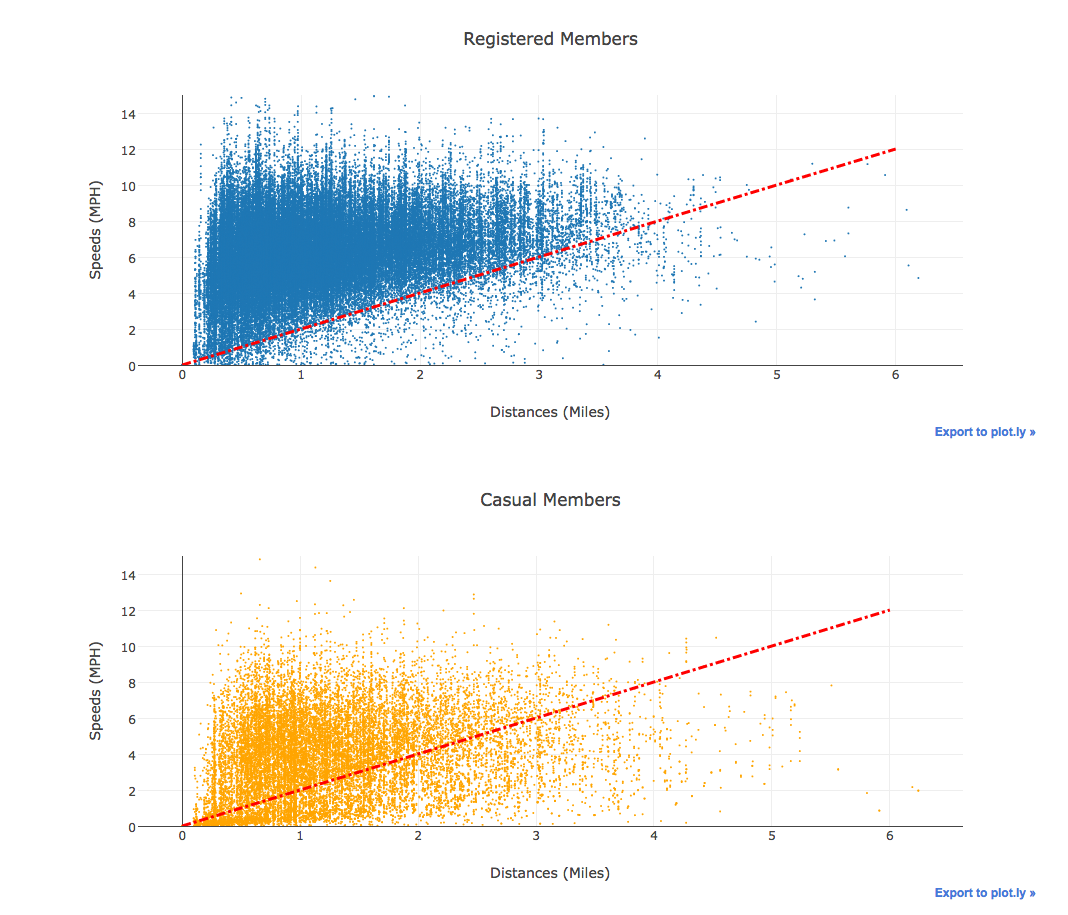

In [14]:
plot_data = [
    Scatter(
        x = registered_distances,
        y = registered_speeds,
        mode = 'markers',
        marker = dict(
            size = 2,
        )
    )
]
layout = Layout(
    title='Registered Members',
    xaxis=dict(
        type='linear',
        title='Distances (Miles)',
    ),
    yaxis=dict(
        title='Speeds (MPH)',
        type='linear',
        range=[0,15]
        
    ),
    shapes = [
        # Line Vertical
        {
            'type': 'line',
            'x0': 0,
            'y0': 0,
            'x1': 6,
            'y1': 12,
            'line': {
                'color': 'red',
                'width': 3,
                'dash': 'dashdot',
            },
        },
    ]
)
fig = Figure(data=plot_data,layout=layout)
#iplot(fig)

plot_data = [
    Scatter(
        x = casual_distances,
        y = casual_speeds,
        mode = 'markers',
        marker = dict(
            size = 2,
            color = 'orange'
        )
    )
]
layout = Layout(
    title='Casual Members',
    xaxis=dict(
        type='linear',
        title='Distances (Miles)',
    ),
    yaxis=dict(
        title='Speeds (MPH)',
        type='linear',
        range=[0,15]
        
    ),
    shapes = [
        # Line Vertical
        {
            'type': 'line',
            'x0': 0,
            'y0': 0,
            'x1': 6,
            'y1': 12,
            'line': {
                'color': 'red',
                'width': 3,
                'dash': 'dashdot',
            },
        },
    ]
)
fig = Figure(data=plot_data,layout=layout)
#iplot(fig)
Image('scatterplots.png')

It looks as if registered members are better as a group at staying below the 30 min line. They likely know better and probably care more about their times (i.e. money) if they are frequent users.

# Conclusions, for now

There's a lot of interesting data in the Capital Bikeshare usage history. It's lacking some data compared to the Seattle dataset, but it also is a larger dataset. We couldn't investigate the effects of weather and so far we haven't looked at elevation changes.

So what were we able to determine?
* Casual and registered members are just as different in DC as they are in Seattle. Their behavioral patterns are basically what you would expect though regarding usage days and times.

* Registered members are more aware or more concerned with paying overage charges than the casual users, and, perhaps related, registered users are typically faster travelers.

* Capital Bikeshare does not use the same data format over time.